Hi! This is a sklearn classification example built with inspiration from https://stackabuse.com/decision-trees-in-python-with-scikit-learn/

The link contains additional explanitory text and short 5-minute youtube video explaining core concepts.

In [1]:
### SKLEARN CLASSIFICATION EXAMPLE
# 
# Author: Rasmus F. Ørsøe
# email: pcs557@alumni.ku.dk
#
import sys
from io import StringIO
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Load 2nd version of the Aleph Data. Why not the first?
path = 'AlephBtag_MC_small_v2.csv'
data = pd.DataFrame(np.genfromtxt(path, names=True))
variables = data.columns
print(variables)

Index(['energy', 'cTheta', 'phi', 'prob_b', 'spheri', 'pt2rel', 'multip',
       'bqvjet', 'ptlrel', 'nnbjet', 'isb'],
      dtype='object')


Remember: 'isb' is our binary truth. If isb = 1 then it's a b-quark and isb = 0 if it is not. Because this is our truth, we must not include it as the input to our model. Also, 'nnbjet' is our "competitor" e.g. a model we are supposed to benchmark against. Therefore 'nnbjet' shouldn't be in our input either. Usually one would apply regularization/standardization of data at this step - but lets skip this for now and just move onto seperate the data into input, truth and benchmark:

In [2]:
input_variables = variables[(variables != 'nnbjet') & (variables != 'isb')]
input_data      = data[input_variables]
truth           = data['isb']
benchmark       = data['nnbjet']
print(input_variables)

Index(['energy', 'cTheta', 'phi', 'prob_b', 'spheri', 'pt2rel', 'multip',
       'bqvjet', 'ptlrel'],
      dtype='object')


Let us now divide the truth and input_data into two parts; a training sample and a validation sample:

In [3]:
input_train, input_valid, truth_train, truth_valid = train_test_split(input_data, truth, test_size=0.25, random_state=42)

Let us now define the scikit-learn model:

In [4]:
model = DecisionTreeClassifier(min_samples_leaf = 20, criterion = 'entropy') 

Now we are ready to train! 

In [5]:
print('--------- TRAINING ---------')
model.fit(np.array(input_train), np.array(truth_train))  ## This trains the model on input_train by comparing to the true values in truth_train.
print('----------TRAINING DONE -----')    



--------- TRAINING ---------
----------TRAINING DONE -----


Now we have a trained model and we're ready to make predictions. Usually, one would have a test set (so in total one would have; a training set, a validation set AND a test set). But for simplicity, let's just predict on the validation sample. This is OK because the model has not trained on this set - if we asked the model to predict on examples on which it has trained, we would be cheating!

In [6]:
predictions = model.predict_proba(input_valid) # this asks the trained model to make predictions on input_valid. Notice we're not giving it any truth values!

predictions = pd.DataFrame(predictions)
predictions.columns = ['not_bquark', 'bquark']
predictions = (predictions['bquark'])/(predictions['bquark'] + predictions['not_bquark'])

We can now evaluate our predictions by producing a ROC-curve and calculating the AUC-score and comparing it to our 'nnbjet' competitor. You can read more about ROC curves and AUC scores in 
https://mlwhiz.com/blog/2021/02/03/roc-auc-curves-explained/ (and by attending Troel's lectures!)

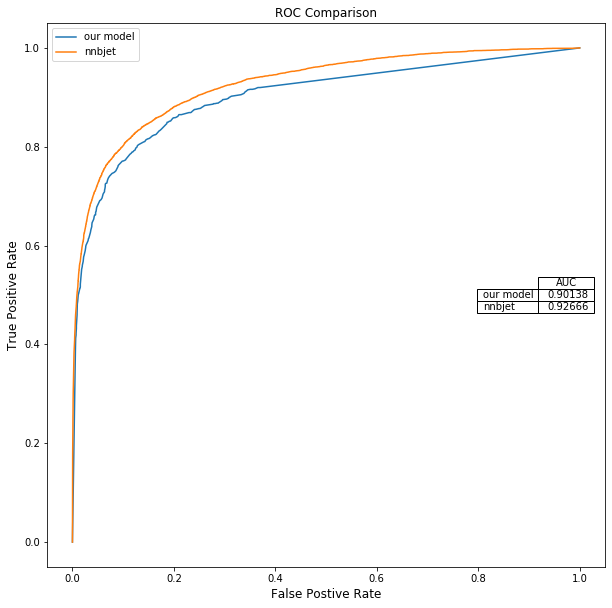

In [7]:
fpr, tpr, _ = roc_curve(truth_valid, predictions)  ## this calculates the false positive rate and the true positive rate for our model's predictions on the validation sample
fpr_nnbjet, tpr_nnbjet, _ = roc_curve(truth,benchmark) ## this calculates the false positive rate and the true postive rate for nnbjet on the entire data sample

### We can npw calculate the AUC scores of these ROC-curves
auc_score = auc(fpr,tpr)                      # this is auc score for our model
auc_score_nnbjet = auc(fpr_nnbjet, tpr_nnbjet)# this is the auc score for nnbjet


### Let's plot the results

fig = plt.figure(figsize = [10,10])
plt.title('ROC Comparison', size = 12)
plt.plot(fpr,tpr, label = 'our model')
plt.plot(fpr_nnbjet, tpr_nnbjet, label = 'nnbjet')
plt.legend()
plt.xlabel('False Postive Rate', size = 12)
plt.ylabel('True Positive Rate', size = 12)
### This just plots a table with the AUC-scores.
row_labels=['our model',
            'nnbjet']
table_vals=[[round(auc_score,5)],
            [round(auc_score_nnbjet,5)]]
col_labels=['AUC']
the_table = plt.table(cellText=table_vals,
                  colWidths = [0.1]*3,
                  rowLabels=row_labels,
                  colLabels=col_labels,
                  loc='center right')
########



We lost to nnbjet!! . (as higher AUC is better). Can you beat this? 